# Importação das bibliotecas

In [1]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Carregando a base de dados

In [6]:
# Utilizando a base de dados do Fake.br Corpus
base_news = pd.read_csv("pre-processed.csv", sep=",")
base_news

,index,label,preprocessed_news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...
...,...,...,...
7195,7195,true,jornal britanico acao contra lula lava jato se...
7196,7196,true,temer diz acionou pf cade investigar aumentos ...
7197,7197,true,obstaculos politicos temer especialistas ouvid...
7198,7198,true,setembro boa noite aqui estao principais notic...


In [7]:
# Organização do database.
base_news['class'] = base_news['label']
base_news = base_news.drop(columns=['index','label'])
base_news

,preprocessed_news,class
0,katia abreu diz vai colocar expulsao moldura n...,fake
1,ray peita bolsonaro conservador fake entrevist...,fake
2,reinaldo azevedo desmascarado policia federal ...,fake
3,relatorio assustador bndes mostra dinheiro pub...,fake
4,radialista americano fala sobre pt vendem ilus...,fake
...,...,...
7195,jornal britanico acao contra lula lava jato se...,true
7196,temer diz acionou pf cade investigar aumentos ...,true
7197,obstaculos politicos temer especialistas ouvid...,true
7198,setembro boa noite aqui estao principais notic...,true


# Análise dos textos com spaCy

In [8]:
# Importação das stop_words e string para auxiliar na execução de processamento do spacy
from spacy.lang.pt.stop_words import STOP_WORDS
import string
pontuacoes = string.punctuation
stop_words = STOP_WORDS
pln = spacy.load('pt_core_news_sm')

In [9]:
# Função para remover stop word, pontuações e digitos.
def preprocessamento(texto):
    texto = texto.lower()
    documento = pln(texto)
    
    lista = []
    for token in documento:
        #lista.append(token.text)
        lista.append(token.lemma_)
        
    lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacoes]
    lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
    
    return lista

In [10]:
base_news["new_preprocessed"] = base_news['preprocessed_news'].apply(preprocessamento)

In [11]:
base_news

,preprocessed_news,class,new_preprocessed
0,katia abreu diz vai colocar expulsao moldura n...,fake,katia abreu colocar expulsao moldurar nao recl...
1,ray peita bolsonaro conservador fake entrevist...,fake,ray peitar bolsonaro conservador fake entrevis...
2,reinaldo azevedo desmascarado policia federal ...,fake,reinaldo azevedo desmascarar policiar federal ...
3,relatorio assustador bndes mostra dinheiro pub...,fake,relatorio assustador bndes mostrar dinheiro pu...
4,radialista americano fala sobre pt vendem ilus...,fake,radialista americano falir sobrar pt vender il...
...,...,...,...
7195,jornal britanico acao contra lula lava jato se...,true,jornal britanico acao lula lavar jato sera jul...
7196,temer diz acionou pf cade investigar aumentos ...,true,temer acionou pf cade investigar aumento preco...
7197,obstaculos politicos temer especialistas ouvid...,true,obstaculos politicos temer especialista ouvir ...
7198,setembro boa noite aqui estao principais notic...,true,setembro noite estao principal noticiar voce t...


# Criação de um WordCloud

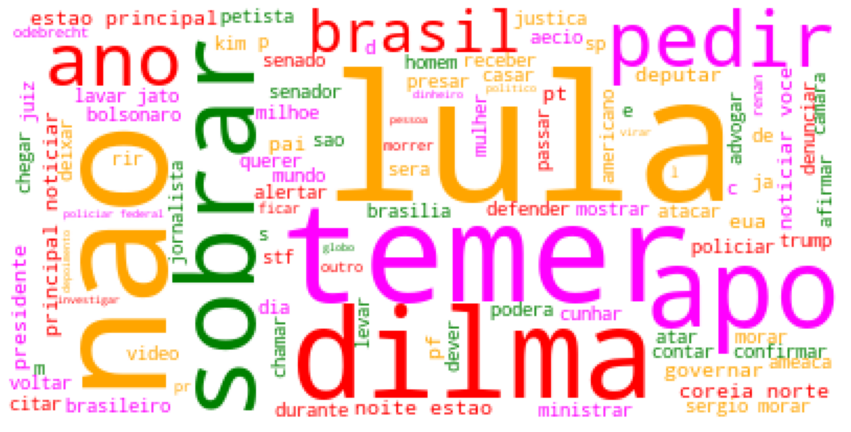

In [12]:
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
color_map = ListedColormap(['orange', 'green', 'red', 'magenta'])
cloud = WordCloud(background_color = 'white', max_words=100, colormap=color_map)

cloud = cloud.generate(base_news["new_preprocessed"].to_string())
plt.figure(figsize=(15,15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [13]:
frases = []
classes = []
soma_fake = 0
soma_true = 0

for frase, classe in zip(base_news['new_preprocessed'], base_news['class']):
    if 'lula' in frase:
        frases.append(frase)
        classes.append(classe)
        
resultado_df = pd.DataFrame({'Frases': frases, 'Classe': classes})
resultado_df     

,Frases,Classe
0,edir macedo podera disputar eleicoes presidenc...,fake
1,boechat sobrar lula almo honesto governar diab...,fake
2,pt lula nao dinheiro sobreviver chamar morar m...,fake
3,lula voce nao moleque sofrer dono friboi antar...,fake
4,lula receber intimacao justica escrever letra ...,fake
...,...,...
2294,brasilia carro silenciar profundar costumar se...,true
2295,mpf querer ouvir lula dilma mantega sobrar con...,true
2296,fase operacao ourar cumprir mandar prisao apre...,true
2297,retrospectivo relembrar fato marcar acre ano g...,true


In [14]:
resultado_agrupado = resultado_df.groupby('Classe').count()
resultado_agrupado['Porcentagem'] = [1029/2299*100,1270/2299*100]
resultado_agrupado

,Frases,Porcentagem
Classe,,
fake,1029,44.758591
true,1270,55.241409


# Separação dos atributos em X e y


In [15]:
# Separar os atributos independentes (X = coluna preprocessed_news) e atributo independente (y = coluna class)
X_base_news = base_news.iloc[:,0]
y_base_news = base_news.iloc[:,1]

In [16]:
X_base_news

0       katia abreu diz vai colocar expulsao moldura n...
1       ray peita bolsonaro conservador fake entrevist...
2       reinaldo azevedo desmascarado policia federal ...
3       relatorio assustador bndes mostra dinheiro pub...
4       radialista americano fala sobre pt vendem ilus...
                              ...                        
7195    jornal britanico acao contra lula lava jato se...
7196    temer diz acionou pf cade investigar aumentos ...
7197    obstaculos politicos temer especialistas ouvid...
7198    setembro boa noite aqui estao principais notic...
7199    envolvo politica diz brasileiro preso venezuel...
Name: preprocessed_news, Length: 7200, dtype: object

In [17]:
y_base_news

0       fake
1       fake
2       fake
3       fake
4       fake
        ... 
7195    true
7196    true
7197    true
7198    true
7199    true
Name: class, Length: 7200, dtype: object

# Transformando textos em cadeias de números

In [19]:
#utilizaremos a biblioteca TfidfVectorizer para essa transformação.
vetorizador = TfidfVectorizer()
X_base_news_vetorizado = vetorizador.fit_transform(X_base_news)
X_base_news_vetorizado.shape

(7200, 79541)

# Separando as bases entre treinamento e teste

In [94]:
X_base_news_treinamento, X_base_news_teste, y_base_news_treinamento, y_base_news_teste = \
train_test_split(X_base_news_vetorizado, y_base_news, test_size=0.15, random_state=1)

In [95]:
X_base_news_treinamento.shape, y_base_news_treinamento.shape

((6120, 79541), (6120,))

In [96]:
X_base_news_teste.shape, y_base_news_teste.shape

((1080, 79541), (1080,))

# Treinando as redes neurais

In [97]:
rede_neural_news = MLPClassifier(max_iter=1500, tol=0.0000100, solver='adam', activation = 'relu', hidden_layer_sizes = (5,5))
rede_neural_news.fit(X_base_news_treinamento, y_base_news_treinamento)

MLPClassifier(hidden_layer_sizes=(5, 5), max_iter=1500, tol=1e-05)

In [98]:
previsoes = rede_neural_news.predict(X_base_news_teste)

In [99]:
previsoes

array(['fake', 'true', 'fake', ..., 'true', 'true', 'true'], dtype='<U4')

In [100]:
y_base_news_teste

7152    true
6074    true
1790    fake
3242    fake
4067    true
        ... 
4760    true
1991    fake
4616    true
5146    true
4532    true
Name: class, Length: 1080, dtype: object

In [101]:
accuracy_score(y_base_news_teste,previsoes)

0.95

In [102]:
confusion_matrix(y_base_news_teste,previsoes)

array([[508,  29],
       [ 25, 518]], dtype=int64)

In [103]:
print(classification_report(y_base_news_teste,previsoes))

              precision    recall  f1-score   support

        fake       0.95      0.95      0.95       537
        true       0.95      0.95      0.95       543

    accuracy                           0.95      1080
   macro avg       0.95      0.95      0.95      1080
weighted avg       0.95      0.95      0.95      1080

